In [38]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
import json
import unicodedata
import numpy as np
import ast
from sklearn.impute import KNNImputer
import seaborn as sns
import joblib
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath('../src'))

from data_preparation_utils import load_data
pd.set_option('display.max_columns', None)

In [2]:
from model_utils import prepare_data, convert_object_columns, target_encode_columns

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVR, LinearSVC
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from itertools import product
from sklearn.preprocessing import StandardScaler

# load/save data

In [5]:
# Load processed data
df = load_data(r"G:\My Drive\french_resturants\data\processed\french_resturants_only.csv")

In [37]:
#save data frame
df.to_csv(r"G:\My Drive\french_resturants\data\processed\french_resturants_ready_for_modeling.csv", index=False)

In [7]:
# Load ready to model data
df = load_data(r"G:\My Drive\french_resturants\data\processed\french_resturants_ready_for_modeling.csv")

# prepare data for modeling

In [6]:
df.head()

,successful,region,province,city,claimed,awards,top_tags,price_level,price_range,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,default_language,accepts american express,accepts credit cards,accepts discover,accepts mastercard,accepts visa,afghani,african,after hours,albanian,algerian,american,apulian,arabic,argentinian,armenian,asian,assyrian,australian,austrian,azerbaijani,bahamian,bakeries,balti,bangladeshi,bar,barbecue,basque,beach,beer restaurants,beijing cuisine,beijing specialties,belgian,brazilian,breakfast,brew pub,british,brunch,buffet,burmese,byob,cafe,cajun creole,calabrian,cambodian,campania,canadian,cantonese,caribbean,cash only,catalan,caucasian,central american,central asian,central european,central italian,cheap eats,chilean,chinese,colombian,contemporary,costa rican,croatian,cuban,czech,danish,deli,delivery,delivery only,dessert,digital payments,dine with a local chef,diner,dining bars,dinner,dog friendly,drinks,drive thru,dutch,eastern european,ecuadorean,egyptian,emilian,ethiopian,european,family style,fast food,fine dining,free off street parking,free wifi,french,fruit parlours,fujian,full bar,fusion,gastropub,georgian,german,gift cards available,gluten free options,greek,grill,guangxi,guatemalan,halal,hawaiian,healthy,highchairs available,hokkaido cuisine,hong kong,hubei,hunan,hungarian,imperial chinese,indian,indonesian,international,irish,israeli,italian,jamaican,japanese,japanese fusion,japanese sweets parlour,jazz bar,kaiseki,kappo,korean,kosher,kyoto cuisine,kyushu cuisine,latin,latvian,lazio,lebanese,ligurian,live music,lombard,lunch,malaysian,medicinal foods,mediterranean,mexican,mid range,middle eastern,mongolian,moroccan,native american,neapolitan,nepalese,new zealand,nigerian,non smoking restaurants,northeastern chinese,northern italian,northwestern chinese,norwegian,outdoor seating,pakistani,parking available,persian,peruvian,philippine,pizza,playgrounds,polish,polynesian,portuguese,private dining,pub,puerto rican,quick bites,reservations,romagna,romana,romanian,russian,salvadoran,sardinian,scandinavian,scottish,seafood,seating,serves alcohol,shandong,shanghai,sicilian,singaporean,slovenian,soups,south american,southern italian,southwestern,spanish,speciality food market,sports bars,sri lankan,steakhouse,street food,street parking,sushi,swedish,swiss,szechuan,table service,taiwanese,takeout,television,thai,tibetan,tunisian,turkish,tuscan,ukrainian,uzbek,valet parking,validated parking,vegan options,vegetarian friendly,venezuelan,vietnamese,waterfront,welsh,wheelchair accessible,wine and beer,wine bar,xinjiang,yunnan,zhejiang,award_count,moved_location,mon_open_1st,mon_close_1st,mon_open_2nd,mon_close_2nd,tue_open_1st,tue_close_1st,tue_open_2nd,tue_close_2nd,wed_open_1st,wed_close_1st,wed_open_2nd,wed_close_2nd,thu_open_1st,thu_close_1st,thu_open_2nd,thu_close_2nd,fri_open_1st,fri_close_1st,fri_open_2nd,fri_close_2nd,sat_open_1st,sat_close_1st,sat_open_2nd,sat_close_2nd,sun_open_1st,sun_close_1st,sun_open_2nd,sun_close_2nd,rank,total_restaurants_in_city
0,N,nouvelle aquitaine,haute vienne,saint jouvent,claimed,0 or unknown,"cheap eats, french",€,Unknown,"lunch, dinner",french,Missing,"reservations, seating, wheelchair accessible, ...",N,N,N,7,46.066667,14,english,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,0 or unknown,N,13:30,19:15,22:45,23:30,11:45,16:40,21:30,23:00,11:45,16:30,21:00,23:00,11:30,15:45,20:15,22:45,11:00,15:45,20:00,22:40,11:50,16:30,20:30,22:50,15:00,19:30,23:01,23:45,1.0,2.0

## trnsofrm columns type

In [9]:
# transform columns type
df = convert_object_columns(df, 
                            force_category=['region', 'province', 'city'], 
                            force_string=['top_tags', 'awards', 'meals', 'cuisines', 'special_diets', 'features'])

In [10]:
# Print summary of column data types
dtype_summary = df.dtypes.value_counts()
print("Summary of column data types:")
print(dtype_summary)

Summary of column data types:
boolean           232
string[python]      6
int64               2
category            1
category            1
category            1
category            1
category            1
category            1
float64             1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
Name: count, dtype: int6

In [11]:
# Select columns with boolean dtypes (including both native bool and pandas BooleanDtype)
bool_cols = df.select_dtypes(include=['bool', 'boolean']).columns

# Convert them to integer (0/1)
df[bool_cols] = df[bool_cols].astype(int)

In [14]:
df.head()

,successful,region,province,city,claimed,awards,top_tags,price_level,price_range,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,default_language,accepts american express,accepts credit cards,accepts discover,accepts mastercard,accepts visa,afghani,african,after hours,albanian,algerian,american,apulian,arabic,argentinian,armenian,asian,assyrian,australian,austrian,azerbaijani,bahamian,bakeries,balti,bangladeshi,bar,barbecue,basque,beach,beer restaurants,beijing cuisine,beijing specialties,belgian,brazilian,breakfast,brew pub,british,brunch,buffet,burmese,byob,cafe,cajun creole,calabrian,cambodian,campania,canadian,cantonese,caribbean,cash only,catalan,caucasian,central american,central asian,central european,central italian,cheap eats,chilean,chinese,colombian,contemporary,costa rican,croatian,cuban,czech,danish,deli,delivery,delivery only,dessert,digital payments,dine with a local chef,diner,dining bars,dinner,dog friendly,drinks,drive thru,dutch,eastern european,ecuadorean,egyptian,emilian,ethiopian,european,family style,fast food,fine dining,free off street parking,free wifi,french,fruit parlours,fujian,full bar,fusion,gastropub,georgian,german,gift cards available,gluten free options,greek,grill,guangxi,guatemalan,halal,hawaiian,healthy,highchairs available,hokkaido cuisine,hong kong,hubei,hunan,hungarian,imperial chinese,indian,indonesian,international,irish,israeli,italian,jamaican,japanese,japanese fusion,japanese sweets parlour,jazz bar,kaiseki,kappo,korean,kosher,kyoto cuisine,kyushu cuisine,latin,latvian,lazio,lebanese,ligurian,live music,lombard,lunch,malaysian,medicinal foods,mediterranean,mexican,mid range,middle eastern,mongolian,moroccan,native american,neapolitan,nepalese,new zealand,nigerian,non smoking restaurants,northeastern chinese,northern italian,northwestern chinese,norwegian,outdoor seating,pakistani,parking available,persian,peruvian,philippine,pizza,playgrounds,polish,polynesian,portuguese,private dining,pub,puerto rican,quick bites,reservations,romagna,romana,romanian,russian,salvadoran,sardinian,scandinavian,scottish,seafood,seating,serves alcohol,shandong,shanghai,sicilian,singaporean,slovenian,soups,south american,southern italian,southwestern,spanish,speciality food market,sports bars,sri lankan,steakhouse,street food,street parking,sushi,swedish,swiss,szechuan,table service,taiwanese,takeout,television,thai,tibetan,tunisian,turkish,tuscan,ukrainian,uzbek,valet parking,validated parking,vegan options,vegetarian friendly,venezuelan,vietnamese,waterfront,welsh,wheelchair accessible,wine and beer,wine bar,xinjiang,yunnan,zhejiang,award_count,moved_location,mon_open_1st,mon_close_1st,mon_open_2nd,mon_close_2nd,tue_open_1st,tue_close_1st,tue_open_2nd,tue_close_2nd,wed_open_1st,wed_close_1st,wed_open_2nd,wed_close_2nd,thu_open_1st,thu_close_1st,thu_open_2nd,thu_close_2nd,fri_open_1st,fri_close_1st,fri_open_2nd,fri_close_2nd,sat_open_1st,sat_close_1st,sat_open_2nd,sat_close_2nd,sun_open_1st,sun_close_1st,sun_open_2nd,sun_close_2nd,rank,total_restaurants_in_city
0,0,nouvelle aquitaine,haute vienne,saint jouvent,claimed,0 or unknown,"cheap eats, french",€,Unknown,"lunch, dinner",french,Missing,"reservations, seating, wheelchair accessible, ...",0,0,0,7,46.066667,14,english,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0 or unknown,N,13:30,19:15,22:45,23:30,11:45,16:40,21:30,23:00,11:45,16:30,21:00,23:00,11:30,15:45,20:15,22:45,11:00,15:45,20:00,22:40,11:50,16:30,20:30,22:50,15:00,19:30,23:01,23:45,1.0,2.0

## target encoding for string columns

In [17]:
df['successful'].head()

0    0
1    0
2    0
3    0
4    0
Name: successful, dtype: int64

In [19]:
df = target_encode_columns(df, target_col="successful", columns=None)

## encoding rest of the data

In [22]:
for col in df.columns:
    # Check if the column is not numeric
    if not pd.api.types.is_numeric_dtype(df[col]):
        # Convert to category if not already
        if not pd.api.types.is_categorical_dtype(df[col]):
            df[col] = df[col].astype('category')
        # Replace column with its categorical codes
        df[col] = df[col].cat.codes

In [24]:
# Print summary of column data types
dtype_summary = df.dtypes.value_counts()
print("Summary of column data types:")
print(dtype_summary)

Summary of column data types:
int64      234
int8        35
float64      7
int16        4
Name: count, dtype: int64


# data split for modeling

In [9]:
X_train, X_test, y_train, y_test = prepare_data(df, 'successful')

In [29]:
X_train.head()

,region,province,city,claimed,awards,top_tags,price_level,price_range,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,default_language,accepts american express,accepts credit cards,accepts discover,accepts mastercard,accepts visa,afghani,african,after hours,albanian,algerian,american,apulian,arabic,argentinian,armenian,asian,assyrian,australian,austrian,azerbaijani,bahamian,bakeries,balti,bangladeshi,bar,barbecue,basque,beach,beer restaurants,beijing cuisine,beijing specialties,belgian,brazilian,breakfast,brew pub,british,brunch,buffet,burmese,byob,cafe,cajun creole,calabrian,cambodian,campania,canadian,cantonese,caribbean,cash only,catalan,caucasian,central american,central asian,central european,central italian,cheap eats,chilean,chinese,colombian,contemporary,costa rican,croatian,cuban,czech,danish,deli,delivery,delivery only,dessert,digital payments,dine with a local chef,diner,dining bars,dinner,dog friendly,drinks,drive thru,dutch,eastern european,ecuadorean,egyptian,emilian,ethiopian,european,family style,fast food,fine dining,free off street parking,free wifi,french,fruit parlours,fujian,full bar,fusion,gastropub,georgian,german,gift cards available,gluten free options,greek,grill,guangxi,guatemalan,halal,hawaiian,healthy,highchairs available,hokkaido cuisine,hong kong,hubei,hunan,hungarian,imperial chinese,indian,indonesian,international,irish,israeli,italian,jamaican,japanese,japanese fusion,japanese sweets parlour,jazz bar,kaiseki,kappo,korean,kosher,kyoto cuisine,kyushu cuisine,latin,latvian,lazio,lebanese,ligurian,live music,lombard,lunch,malaysian,medicinal foods,mediterranean,mexican,mid range,middle eastern,mongolian,moroccan,native american,neapolitan,nepalese,new zealand,nigerian,non smoking restaurants,northeastern chinese,northern italian,northwestern chinese,norwegian,outdoor seating,pakistani,parking available,persian,peruvian,philippine,pizza,playgrounds,polish,polynesian,portuguese,private dining,pub,puerto rican,quick bites,reservations,romagna,romana,romanian,russian,salvadoran,sardinian,scandinavian,scottish,seafood,seating,serves alcohol,shandong,shanghai,sicilian,singaporean,slovenian,soups,south american,southern italian,southwestern,spanish,speciality food market,sports bars,sri lankan,steakhouse,street food,street parking,sushi,swedish,swiss,szechuan,table service,taiwanese,takeout,television,thai,tibetan,tunisian,turkish,tuscan,ukrainian,uzbek,valet parking,validated parking,vegan options,vegetarian friendly,venezuelan,vietnamese,waterfront,welsh,wheelchair accessible,wine and beer,wine bar,xinjiang,yunnan,zhejiang,award_count,moved_location,mon_open_1st,mon_close_1st,mon_open_2nd,mon_close_2nd,tue_open_1st,tue_close_1st,tue_open_2nd,tue_close_2nd,wed_open_1st,wed_close_1st,wed_open_2nd,wed_close_2nd,thu_open_1st,thu_close_1st,thu_open_2nd,thu_close_2nd,fri_open_1st,fri_close_1st,fri_open_2nd,fri_close_2nd,sat_open_1st,sat_close_1st,sat_open_2nd,sat_close_2nd,sun_open_1st,sun_close_1st,sun_open_2nd,sun_close_2nd,rank,total_restaurants_in_city
76179,13,31,8989,1,0.002820,0.001443,0,391,0.095365,0.003806,0.053901,0.001880,0,0,0,7,63.000000,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,30,78,52,68,28,77,57,75,31,79,59,75,31,78,66,79,31,77,66,77,30,74,64,73,28,78,58,64,5895,118
78113,13,87,9225,1,0.681092,0.719178,2,391,0.262811,0.644444,0.581040,0.122514,1,0,1,6,19.000000,10,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
X_test.head()

,region,province,city,claimed,awards,top_tags,price_level,price_range,meals,cuisines,special_diets,features,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,default_language,accepts american express,accepts credit cards,accepts discover,accepts mastercard,accepts visa,afghani,african,after hours,albanian,algerian,american,apulian,arabic,argentinian,armenian,asian,assyrian,australian,austrian,azerbaijani,bahamian,bakeries,balti,bangladeshi,bar,barbecue,basque,beach,beer restaurants,beijing cuisine,beijing specialties,belgian,brazilian,breakfast,brew pub,british,brunch,buffet,burmese,byob,cafe,cajun creole,calabrian,cambodian,campania,canadian,cantonese,caribbean,cash only,catalan,caucasian,central american,central asian,central european,central italian,cheap eats,chilean,chinese,colombian,contemporary,costa rican,croatian,cuban,czech,danish,deli,delivery,delivery only,dessert,digital payments,dine with a local chef,diner,dining bars,dinner,dog friendly,drinks,drive thru,dutch,eastern european,ecuadorean,egyptian,emilian,ethiopian,european,family style,fast food,fine dining,free off street parking,free wifi,french,fruit parlours,fujian,full bar,fusion,gastropub,georgian,german,gift cards available,gluten free options,greek,grill,guangxi,guatemalan,halal,hawaiian,healthy,highchairs available,hokkaido cuisine,hong kong,hubei,hunan,hungarian,imperial chinese,indian,indonesian,international,irish,israeli,italian,jamaican,japanese,japanese fusion,japanese sweets parlour,jazz bar,kaiseki,kappo,korean,kosher,kyoto cuisine,kyushu cuisine,latin,latvian,lazio,lebanese,ligurian,live music,lombard,lunch,malaysian,medicinal foods,mediterranean,mexican,mid range,middle eastern,mongolian,moroccan,native american,neapolitan,nepalese,new zealand,nigerian,non smoking restaurants,northeastern chinese,northern italian,northwestern chinese,norwegian,outdoor seating,pakistani,parking available,persian,peruvian,philippine,pizza,playgrounds,polish,polynesian,portuguese,private dining,pub,puerto rican,quick bites,reservations,romagna,romana,romanian,russian,salvadoran,sardinian,scandinavian,scottish,seafood,seating,serves alcohol,shandong,shanghai,sicilian,singaporean,slovenian,soups,south american,southern italian,southwestern,spanish,speciality food market,sports bars,sri lankan,steakhouse,street food,street parking,sushi,swedish,swiss,szechuan,table service,taiwanese,takeout,television,thai,tibetan,tunisian,turkish,tuscan,ukrainian,uzbek,valet parking,validated parking,vegan options,vegetarian friendly,venezuelan,vietnamese,waterfront,welsh,wheelchair accessible,wine and beer,wine bar,xinjiang,yunnan,zhejiang,award_count,moved_location,mon_open_1st,mon_close_1st,mon_open_2nd,mon_close_2nd,tue_open_1st,tue_close_1st,tue_open_2nd,tue_close_2nd,wed_open_1st,wed_close_1st,wed_open_2nd,wed_close_2nd,thu_open_1st,thu_close_1st,thu_open_2nd,thu_close_2nd,fri_open_1st,fri_close_1st,fri_open_2nd,fri_close_2nd,sat_open_1st,sat_close_1st,sat_open_2nd,sat_close_2nd,sun_open_1st,sun_close_1st,sun_open_2nd,sun_close_2nd,rank,total_restaurants_in_city
95374,3,65,5207,2,0.002820,0.000000,1,391,0.050748,0.014944,0.053901,0.122514,0,0,0,7,108.000000,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,101,52,68,24,101,57,75,27,104,59,75,26,102,66,79,27,0,66,77,26,0,64,73,24,0,58,64,6313,116
14603,3,48,6236,1,0.002820,0.004396,0,2495,0.122928,0.007183,0.053901,0.122514,0,0,0,7,43.000000,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

In [33]:
y_train.head()

76179    0
78113    1
58204    0
98299    0
5227     0
Name: successful, dtype: int64

In [35]:
y_test.head()

95374    0
14603    0
95722    0
21828    0
18746    0
Name: successful, dtype: int64

# model screening

In [40]:
# Define your models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': xgboost.XGBRegressor(random_state=42)
}

# Prepare a list to store results
results = []

for name, model in models.items():
    # Fit the model on training data
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    # For RMSLE, ensure no negative predictions (and target should be positive)
    y_pred_adj = np.maximum(y_pred, 0)
    y_test_adj = np.maximum(y_test, 0)
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_test_adj), np.log1p(y_pred_adj)))
    
    results.append([name, mse, rmse, mae, rmsle])

# Convert the results list to a DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'RMSE', 'MAE', 'RMSLE'])

# Sort results by RMSE (or another metric of your choice) and display
results_df = results_df.sort_values(by='RMSE', ascending=True)
print(results_df)

               Model       MSE      RMSE       MAE     RMSLE
6            XGBoost  0.030337  0.174176  0.065816  0.121505
4   GradientBoosting  0.031384  0.177157  0.067426  0.123994
2      Random Forest  0.031784  0.178279  0.063785  0.125272
0  Linear Regression  0.036736  0.191668  0.098328  0.134053
3           AdaBoost  0.046414  0.215438  0.110392  0.154224
1      Decision Tree  0.061197  0.247381  0.061197  0.171471
5                SVR  0.087899  0.296477  0.177475  0.207190


**best model: XGBoost**

In [21]:
# Define your grid as dictionary of lists
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10, 15, 25],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Convert param grid to list of dicts (combinations)
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

best_model = None
best_score = float("inf")
best_params = None

for params in param_combinations:
    model = XGBRegressor(objective="reg:squarederror", random_state=42, **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"Params: {params} => RMSE: {rmse:.4f}")
    
    if rmse < best_score:
        best_score = rmse
        best_model = model
        best_params = params

print("\nBest parameters:", best_params)
print("Best RMSE:", best_score)

Params: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1} => RMSE: 0.2596
Params: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 3} => RMSE: 0.2596
Params: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 5} => RMSE: 0.2596
Params: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.1, 'min_child_weight': 1} => RMSE: 0.2596
Params: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.1, 'min_child_weight': 3} => RMSE: 0.2596
Params: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.1, 'min_child_weight': 5} => RMSE: 0.2596
Params: {'n_esti

KeyboardInterrupt: 

In [23]:
print("\nBest parameters:", best_params)
print("Best RMSE:", best_score)


Best parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 0.1, 'min_child_weight': 1}
Best RMSE: 0.17147584646302197


In [11]:
# Your best parameters
base_params = {
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.6,
    'gamma': 0.1,
    'min_child_weight': 1
}

train_sizes = [0.6, 0.7, 0.8]
n_estimators_list = [100, 200]

results = []
predictions_df = pd.DataFrame()

for train_size in train_sizes:
    for n_estimators in n_estimators_list:
        params = base_params.copy()
        params['n_estimators'] = n_estimators

        # Prepare data
        X_train, X_test, y_train, y_test = prepare_data(df, 'successful', train_size=train_size)

        # Train
        model = XGBRegressor(objective='reg:squarederror', random_state=42, **params)
        model.fit(X_train, y_train)

        # Predict on train + test
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # Store results
        results.append({
            'train_size': train_size,
            'n_estimators': n_estimators,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse
        })

        # Add test predictions to a DataFrame for analysis
        run_key = f"train_{int(train_size*100)}_est_{n_estimators}"
        temp_df = pd.DataFrame({
            'true': y_test,
            'predicted': y_test_pred,
            'run': run_key
        })
        predictions_df = pd.concat([predictions_df, temp_df], ignore_index=True)

        print(f"Train size: {train_size}, Estimators: {n_estimators} => "
              f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

Train size: 0.6, Estimators: 100 => Train RMSE: 0.1146 | Test RMSE: 0.1735
Train size: 0.6, Estimators: 200 => Train RMSE: 0.0868 | Test RMSE: 0.1740
Train size: 0.7, Estimators: 100 => Train RMSE: 0.1163 | Test RMSE: 0.1715
Train size: 0.7, Estimators: 200 => Train RMSE: 0.0912 | Test RMSE: 0.1718
Train size: 0.8, Estimators: 100 => Train RMSE: 0.1214 | Test RMSE: 0.1718
Train size: 0.8, Estimators: 200 => Train RMSE: 0.0974 | Test RMSE: 0.1720


**✅ Best parameters for XGBoost (final selection):**

- **Train size:** `0.7`  
- **n_estimators:** `100`  
- **learning_rate:** `0.1`  
- **max_depth:** `10`  
- **subsample:** `1.0`  
- **colsample_bytree:** `0.6`  
- **gamma:** `0.1`  
- **min_child_weight:** `1`  

This model achieved the best balance between training and test RMSE, with strong generalization and minimal overfitting.

# feature importance

In [18]:
# === 1. Set up feature matrix and target
y = df['successful']
X = df.drop(columns=['successful'])

# === 2. Standardize for Lasso/SVM
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# === 3. Fit models and record selections
lasso = Lasso(alpha=0.01).fit(X_scaled, y)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

ridge = Ridge(alpha=0.01).fit(X_scaled, y)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

svm = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=5000).fit(X_scaled, y)
svm_selected = (np.abs(svm.coef_[0]) > 0).astype(int)

gb = GradientBoostingClassifier(random_state=42).fit(X, y)
gb_selected = (gb.feature_importances_ > 0).astype(int)

rf = RandomForestClassifier(random_state=42).fit(X, y)
rf_selected = (rf.feature_importances_ > 0).astype(int)

# === 4. Assemble selection table
selection_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso': lasso_selected,
    'Ridge': ridge_selected,
    'SVM': svm_selected,
    'GradientBoost': gb_selected,
    'RandomForest': rf_selected
})

selection_df['Sum'] = selection_df[['Lasso', 'Ridge', 'SVM', 'GradientBoost', 'RandomForest']].sum(axis=1)

# === 5. Sort by agreement across models
selection_df = selection_df.sort_values(by='Sum', ascending=False)

# Display top 30 features
display(selection_df.head(30))

,Feature,Lasso,Ridge,SVM,GradientBoost,RandomForest,Sum
5,top_tags,1,1,1,1,1,5
4,awards,1,1,1,1,1,5
26,after hours,1,1,1,1,1,5
10,special_diets,1,1,1,1,1,5
9,cuisines,1,1,1,1,1,5
125,highchairs available,1,1,1,1,1,5
15,open_days_per_week,1,1,1,1,1,5
11,features,1,1,1,1,1,5
102,european,1,1,1,1,1,5
1,province,0,1,1,1,1,4


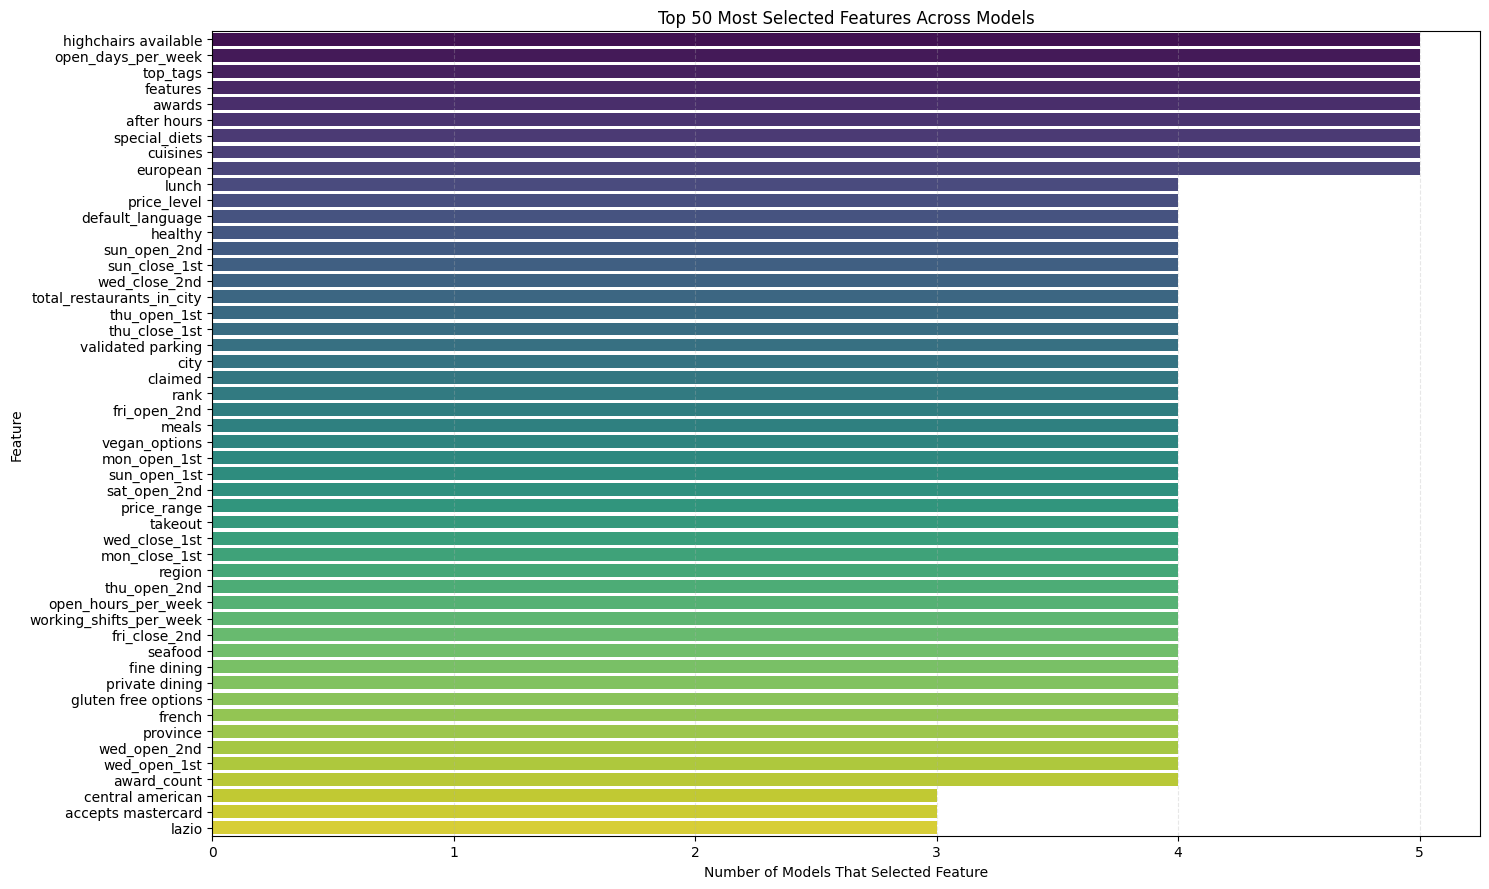

In [34]:
# === Plot configuration ===
top_n = 50  # Change this if you want more or fewer features

# Sort by 'Sum' and get top N
top_features_df = selection_df.sort_values(by='Sum', ascending=False).head(top_n)

# Plot
plt.figure(figsize=(15, 9))
sns.barplot(data=top_features_df, x='Sum', y='Feature', palette='viridis')

plt.title(f"Top {top_n} Most Selected Features Across Models")
plt.xlabel("Number of Models That Selected Feature")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

# Save the figure
plot_path = r"G:\My Drive\french_resturants\outputs\figures\feature_selection_plot.png"
plt.savefig(plot_path, dpi=300)
plt.show()

In [36]:
# Save the selection_df to CSV
csv_path = r"G:\My Drive\french_resturants\outputs\results\feature_selection_summary.csv"
selection_df.to_csv(csv_path, index=False)
print(f"✅ Saved feature selection summary to: {csv_path}")

✅ Saved feature selection summary to: G:\My Drive\french_resturants\outputs\results\feature_selection_summary.csv


## compare model on most important features vs full features

In [40]:
# === 1. Filter top features (based on feature selection)
top_features = selection_df[selection_df['Sum'] >= 4]['Feature'].tolist()

# === 2. Split data using your custom function
X_all_train, X_all_test, y_train, y_test = prepare_data(df, 'successful', train_size=0.7)
X_top_train = X_all_train[top_features]
X_top_test = X_all_test[top_features]

# === 3. Model parameters
params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.6,
    'gamma': 0.1,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# === 4. Train & evaluate on ALL features
model_all = XGBRegressor(**params)
model_all.fit(X_all_train, y_train)
y_train_all = model_all.predict(X_all_train)
y_pred_all = model_all.predict(X_all_test)
rmse_all_train = np.sqrt(mean_squared_error(y_train, y_train_all))
rmse_all_test = np.sqrt(mean_squared_error(y_test, y_pred_all))
gap_all = rmse_all_test - rmse_all_train

# === 5. Train & evaluate on TOP features only
model_top = XGBRegressor(**params)
model_top.fit(X_top_train, y_train)
y_train_top = model_top.predict(X_top_train)
y_pred_top = model_top.predict(X_top_test)
rmse_top_train = np.sqrt(mean_squared_error(y_train, y_train_top))
rmse_top_test = np.sqrt(mean_squared_error(y_test, y_pred_top))
gap_top = rmse_top_test - rmse_top_train

# === 6. Print results
print(f"📊 ALL Features → Train RMSE: {rmse_all_train:.4f} | Test RMSE: {rmse_all_test:.4f} | Gap: {gap_all:.4f}")
print(f"✨ TOP Features → Train RMSE: {rmse_top_train:.4f} | Test RMSE: {rmse_top_test:.4f} | Gap: {gap_top:.4f}")

# === 7. Save models
model_dir = r"G:\My Drive\french_resturants\outputs\models"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(model_all, os.path.join(model_dir, "xgb_model_all_features.pkl"))
joblib.dump(model_top, os.path.join(model_dir, "xgb_model_top_features.pkl"))
print("✅ Models saved successfully.")

📊 ALL Features → Train RMSE: 0.1163 | Test RMSE: 0.1715 | Gap: 0.0552
✨ TOP Features → Train RMSE: 0.1186 | Test RMSE: 0.1718 | Gap: 0.0532
✅ Models saved successfully.


**✅ Final Model Summary: Top Feature Selection**

After comparing models trained on the full dataset vs. a reduced set of top features, we observed the following:

- **All Features Model**
  - Train RMSE: `0.1163`
  - Test RMSE: `0.1715`
  - Gap: `0.0552`

- **Top Features Model**
  - Train RMSE: `0.1186`
  - Test RMSE: `0.1718`
  - Gap: `0.0532` ✅ *(better generalization)*

Although the RMSE on the test set increased slightly, the **gap between train and test RMSE decreased**, indicating better generalization and less risk of overfitting.

This trade-off is acceptable and even desirable in many cases, especially when:
- Model simplicity is a priority
- Fewer features mean faster training/inference
- Interpretability and robustness improve

👉 **Final model saved here**:  
[📁 Top Features XGBoost Model – Google Drive](https://drive.google.com/drive/folders/1PWMthVR8qUaNZc59Z_GpyOkun9f_jumy?usp=sharing)